# Music Streaming Data

## Exploratory Data Analysis

Initial exploration of the data

In [240]:
# Data source:
# https://research.atspotify.com/publications/the-music-streaming-sessions-dataset-short-paper/

In [241]:
# import tarfile
# my_tar = tarfile.open('training_set_track_features_mini.tar')
# my_tar.extractall('.') # specify which folder to extract to
# my_tar.close()

In [242]:
# Assumption: that this 'mini' set a representative sample from the larger set that I can work with and draw meaningful conclusions from

In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, GroupShuffleSplit, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve, classification_report
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import MinMaxScaler

In [244]:
log = pd.read_csv('./Data/training_set/log_mini.csv')
tf = pd.read_csv('./Data/track_features/tf_mini.csv') 

In [245]:
log.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


In [246]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   session_id                       167880 non-null  object
 1   session_position                 167880 non-null  int64 
 2   session_length                   167880 non-null  int64 
 3   track_id_clean                   167880 non-null  object
 4   skip_1                           167880 non-null  bool  
 5   skip_2                           167880 non-null  bool  
 6   skip_3                           167880 non-null  bool  
 7   not_skipped                      167880 non-null  bool  
 8   context_switch                   167880 non-null  int64 
 9   no_pause_before_play             167880 non-null  int64 
 10  short_pause_before_play          167880 non-null  int64 
 11  long_pause_before_play           167880 non-null  int64 
 12  hist_user_behavi

In [247]:
log.describe()

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hour_of_day
count,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000
mean,9.325911,17.651823,0.040904,0.767602,0.146635,0.172832,0.038909,0.046259,14.193084
std,5.457638,3.422025,0.198069,0.422363,0.353742,0.378103,0.367295,0.606558,5.996243
min,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,15.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000
50%,9.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,15.000000
75%,14.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.000000
max,20.000000,20.000000,1.000000,1.000000,1.000000,1.000000,60.000000,151.000000,23.000000


In [248]:
# set seaborn style for plotting
sns.set_style('darkgrid')

In [249]:
# How many distinct session ids?
log['session_id'].nunique()

10000

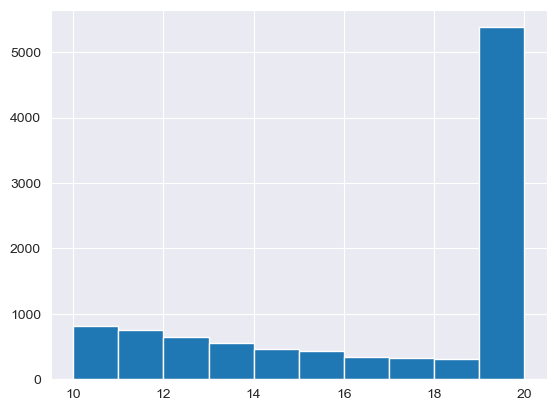

In [250]:
# Distribution of session lengths
session_lengths = log.groupby(by='session_id').agg(['max','count'])['session_length']
plt.hist(session_lengths['max'])
plt.show()

In [251]:
# Average tracks per session
log['session_id'].count()/log['session_id'].nunique()

16.788

In [252]:
# Spread of context types
log.value_counts('context_type')

context_type
user_collection          67430
catalog                  38263
editorial_playlist       35663
radio                    21107
personalized_playlist     2976
charts                    2441
dtype: int64

In [253]:
# Function to more easily plot bar graphs
def plot_bar(df):
    plt.bar(x=df.index, height=df[0])
    plt.xticks(rotation=90)
    plt.show()

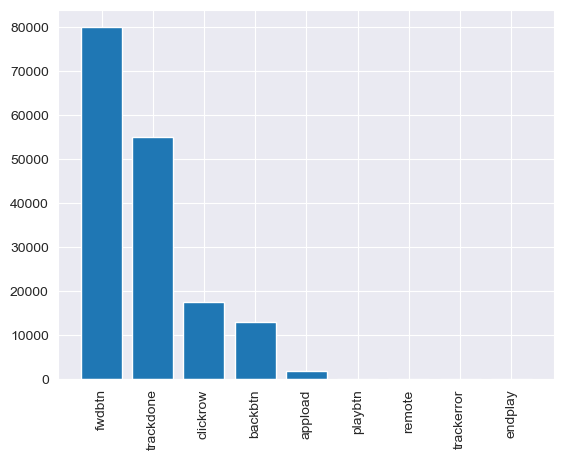

In [254]:
# Spread of hist_user_behavior_reason_start
reason_start_count = log.value_counts('hist_user_behavior_reason_start').to_frame()
plot_bar(reason_start_count)

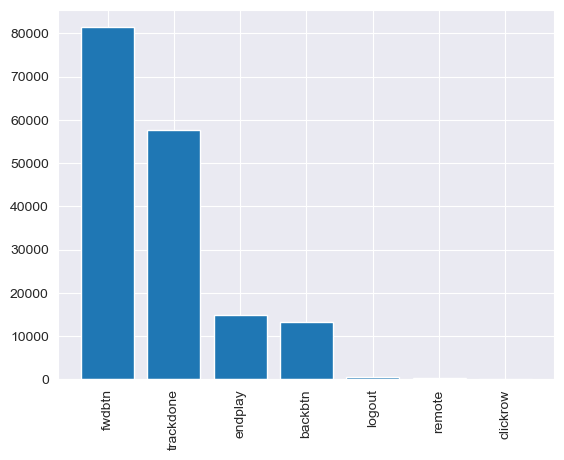

In [255]:
# Spread of hist_user_behavior_reason_end
reason_end_count = log.value_counts('hist_user_behavior_reason_end').to_frame()
plot_bar(reason_end_count)

In [256]:
# skip_1: whether the track was only played very briefly
# skip_2: whether the track was only played briefly
# skip_3: whether most of the track was played
# not_skipped: whether the track was played in its entirety

In [257]:
log[['not_skipped', 'skip_1', 'skip_2', 'skip_3']].value_counts()

not_skipped  skip_1  skip_2  skip_3
False        True    True    True      70762
True         False   False   False     55884
False        False   False   True      22027
                     True    True      16061
                     False   False      3145
                     True    False         1
dtype: int64

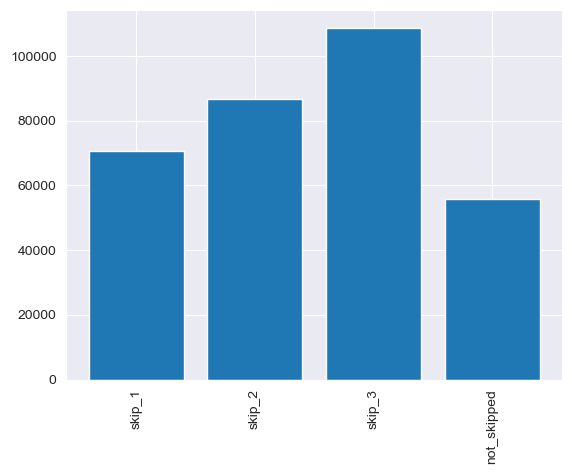

In [258]:
skip_totals = log[['skip_1', 'skip_2', 'skip_3','not_skipped']].sum().to_frame()
plot_bar(skip_totals)

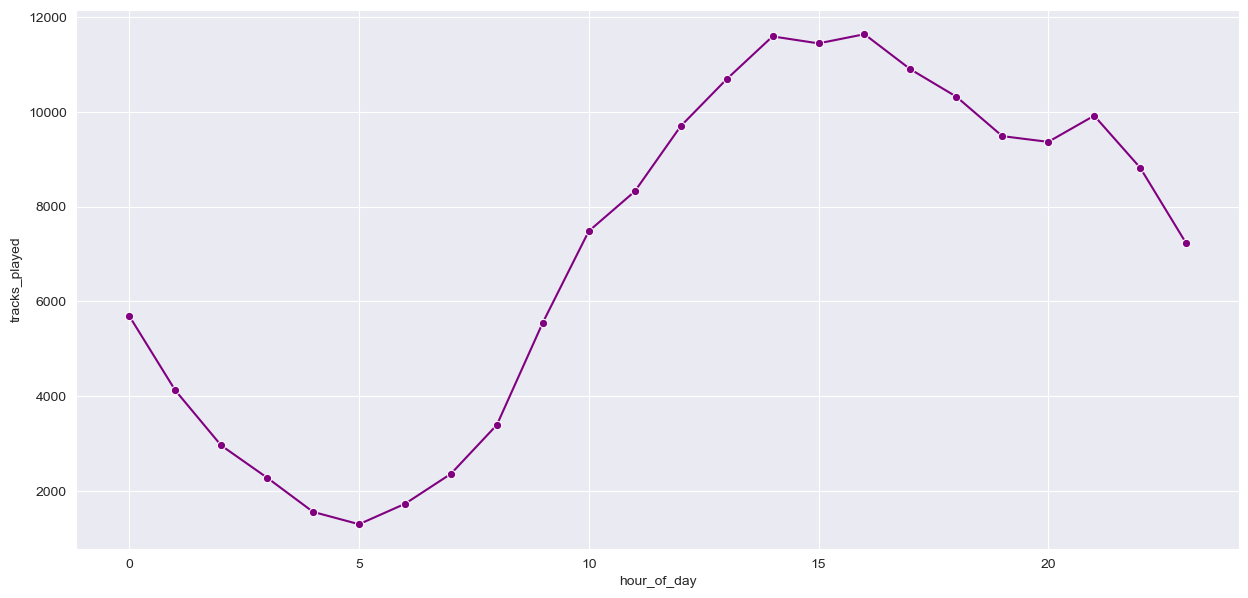

In [259]:
# How does listening behaviour vary by time of day?
time_of_day_count = log['hour_of_day'].value_counts().reset_index().sort_values(by='index').rename(columns={'index':'hour_of_day','hour_of_day':'tracks_played'})

plt.subplots(figsize=(15,7))
sns.lineplot(data=time_of_day_count, x="hour_of_day", y="tracks_played",color='purple',marker='o')
plt.show()

In [260]:
# there is a clear daily seasonal trend in listening habits of users

In [261]:
# Ok so recommendations .. taking skipping/not skipping as indication of successful recommendations .. 
# would have to think about new users as well .. compare to similar users (could look at dot product of tracks) ..
# could be an issue there around the sheer volume of tracks on Spotify
# when I skip a track it's not always because I don't like it, it might be that I'm not in the mood for it
# so based on session history to date .. use that information to understand mood and whether someone will like 
# (i.e. not skip the next track recommended)
# user moods? try and group by track features?

In [262]:
# Could look at some sort of binary classification .. given a session ...

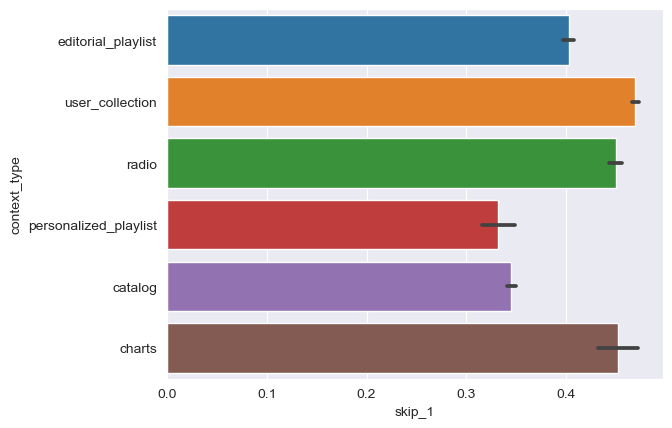

In [263]:
sns.barplot(data=log, x='skip_1', y='context_type')
plt.show()

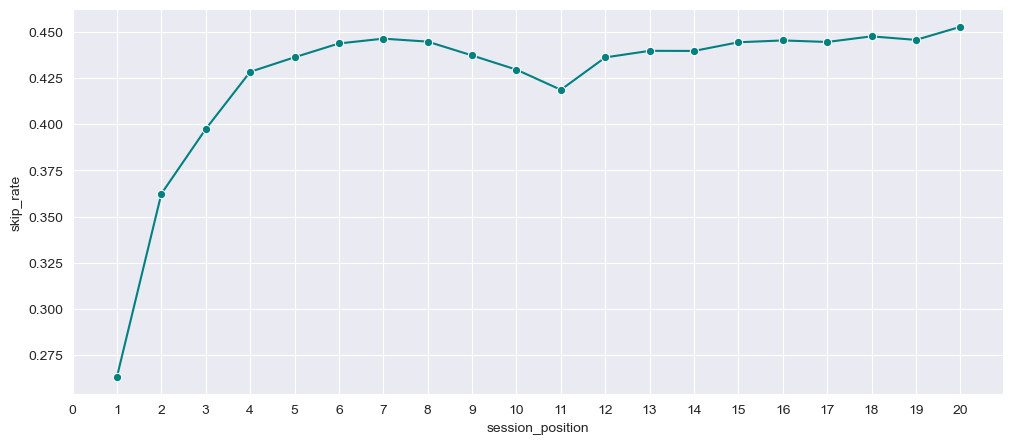

In [264]:
# Skip rate by session position
skip_rates = log.groupby(by='session_position').agg(['count','mean'])['skip_1'].sort_values(by='count',ascending=False).rename(columns={'mean':'skip_rate'})
plt.subplots(figsize=(12,5))
sns.lineplot(data=skip_rates, x="session_position", y="skip_rate", color='teal', marker='o')
plt.xticks(range(21))
plt.show()

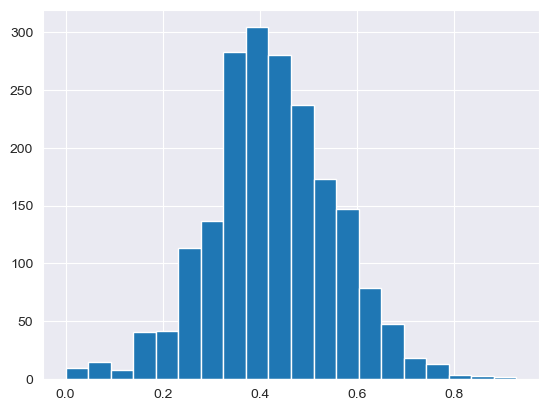

In [265]:
# See distribution of skip_1 metric by track
skip_rates = log.groupby(by='track_id_clean').agg(['count','mean'])['skip_1'].sort_values(by='count',ascending=False)
skip_rates[skip_rates['count']>10]['mean'].hist(bins=20) # Filter to avoid skew from tracks with very few listens
plt.show()

In [266]:
# rating scale from how much of the song is skipped? ...
# i.e. is that a good recommendation in context?

In [267]:
print(log['date'].min(), log['date'].max())

2018-05-12 2018-07-16


In [268]:
# Recommendation engine..
# Difficulties might be in identifying active vs passive listening ...
# Also sequential 
# Also not really understanding why there is such a high count of skip_1, skip_2, skip_3 all equal True where not_skipped = False


In [269]:
# Maybe wanna do a multi-output binary classification on skip?
# Based on features such as acoustic features of that song vs previous song, is previous song skipped, 
# position in session, context_switch,
# context_type vs previous context types, hist_user_behavior_reason_start, shuffle, no_pause_before_play,
# short_pause_before_play, long_pause_before_play
# Or let's just do skip_1 True or False binary - same features as above

In [270]:
# And then a recommendation engine?
# Btw keep these comments until you've done the write up because there will be useful bits in here around thought process

In [271]:
tf.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,...,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,...,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,...,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


In [272]:
tf.columns

Index(['track_id', 'duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector_7'],
      dtype='object')

## Data pre-processing

In [462]:
# Append the tracks info to session information

In [463]:
df = pd.merge(log, tf, left_on = 'track_id_clean', right_on = 'track_id')

In [464]:
df.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,1,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826


In [465]:
tf.describe()

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
count,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,...,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000
mean,222.267980,2010.324748,99.455131,0.250336,0.492075,0.514526,0.611742,8.215950,0.641440,0.996548,...,3.913163,0.487804,-0.332295,0.202193,0.153935,-0.040526,-0.027247,0.049475,-0.197758,0.005153
std,72.224839,11.471866,1.139222,0.276047,0.158102,0.182595,0.166146,2.410626,0.207957,0.045611,...,0.410036,0.246376,0.416320,0.254024,0.212660,0.333129,0.377457,0.144205,0.349840,0.324259
min,30.013330,1950.000000,90.018900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.122792,-1.084360,-0.752231,-0.809136,-1.029858,-0.942461,-0.736395,-0.975647
25%,183.933334,2009.000000,99.509670,0.025291,0.374378,0.372463,0.502499,6.356671,0.507839,0.975910,...,4.000000,0.292559,-0.745148,0.086460,0.051604,-0.294574,-0.318751,-0.038337,-0.444849,-0.176821
50%,214.866669,2015.000000,99.865444,0.135821,0.493764,0.522266,0.625145,8.015075,0.661368,1.003790,...,4.000000,0.478244,-0.334799,0.265535,0.207705,-0.001755,-0.176974,0.062719,-0.298599,0.090423
75%,250.426666,2017.000000,99.961131,0.406142,0.604994,0.655912,0.736241,9.792092,0.803185,1.026137,...,4.000000,0.677947,0.045921,0.359553,0.296132,0.146828,0.280852,0.160366,-0.075158,0.194285
max,1787.760986,2018.000000,99.999997,0.995796,0.990419,0.972590,0.984952,32.342781,0.999877,1.103213,...,5.000000,0.999990,0.932165,0.812837,0.605288,1.074504,0.895769,0.380279,0.966760,1.152213


In [466]:
# for histograms of continuous features
log_features = ['session_position', 'hour_of_day']

tf_features = ['duration', 'us_popularity_estimate', 'acousticness', 
               'beat_strength', 'bounciness', 'danceability', 
               'dyn_range_mean', 'energy', 'flatness', 
               'instrumentalness','liveness', 'loudness', 
               'mechanism', 'mode', 'organism', 
               'speechiness', 'tempo', 'valence']

tf[tf_features].describe()

,duration,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence
count,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,5.070400e+04,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000,50704.000000
mean,222.267980,99.455131,0.250336,0.492075,0.514526,0.611742,8.215950,0.641440,0.996548,7.058671e-02,0.205520,-7.519316,0.547603,0.391874,0.122998,121.576396,3.913163,0.487804
std,72.224839,1.139222,0.276047,0.158102,0.182595,0.166146,2.410626,0.207957,0.045611,2.142261e-01,0.176486,3.927858,0.223803,0.207116,0.136022,29.786741,0.410036,0.246376
min,30.013330,90.018900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,183.933334,99.509670,0.025291,0.374378,0.372463,0.502499,6.356671,0.507839,0.975910,1.084167e-08,0.098249,-8.942000,0.366652,0.225742,0.038028,97.158997,4.000000,0.292559
50%,214.866669,99.865444,0.135821,0.493764,0.522266,0.625145,8.015075,0.661368,1.003790,2.211650e-06,0.131403,-6.688000,0.571023,0.364057,0.061794,120.115498,4.000000,0.478244
75%,250.426666,99.961131,0.406142,0.604994,0.655912,0.736241,9.792092,0.803185,1.026137,7.654784e-04,0.262823,-5.043000,0.729537,0.533131,0.160202,141.014008,4.000000,0.677947
max,1787.760986,99.999997,0.995796,0.990419,0.972590,0.984952,32.342781,0.999877,1.103213,9.993988e-01,0.996257,1.634000,1.000000,0.962350,0.961408,218.774994,5.000000,0.999990


/Users/el_zy/opt/anaconda3/envs/jupyter-notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


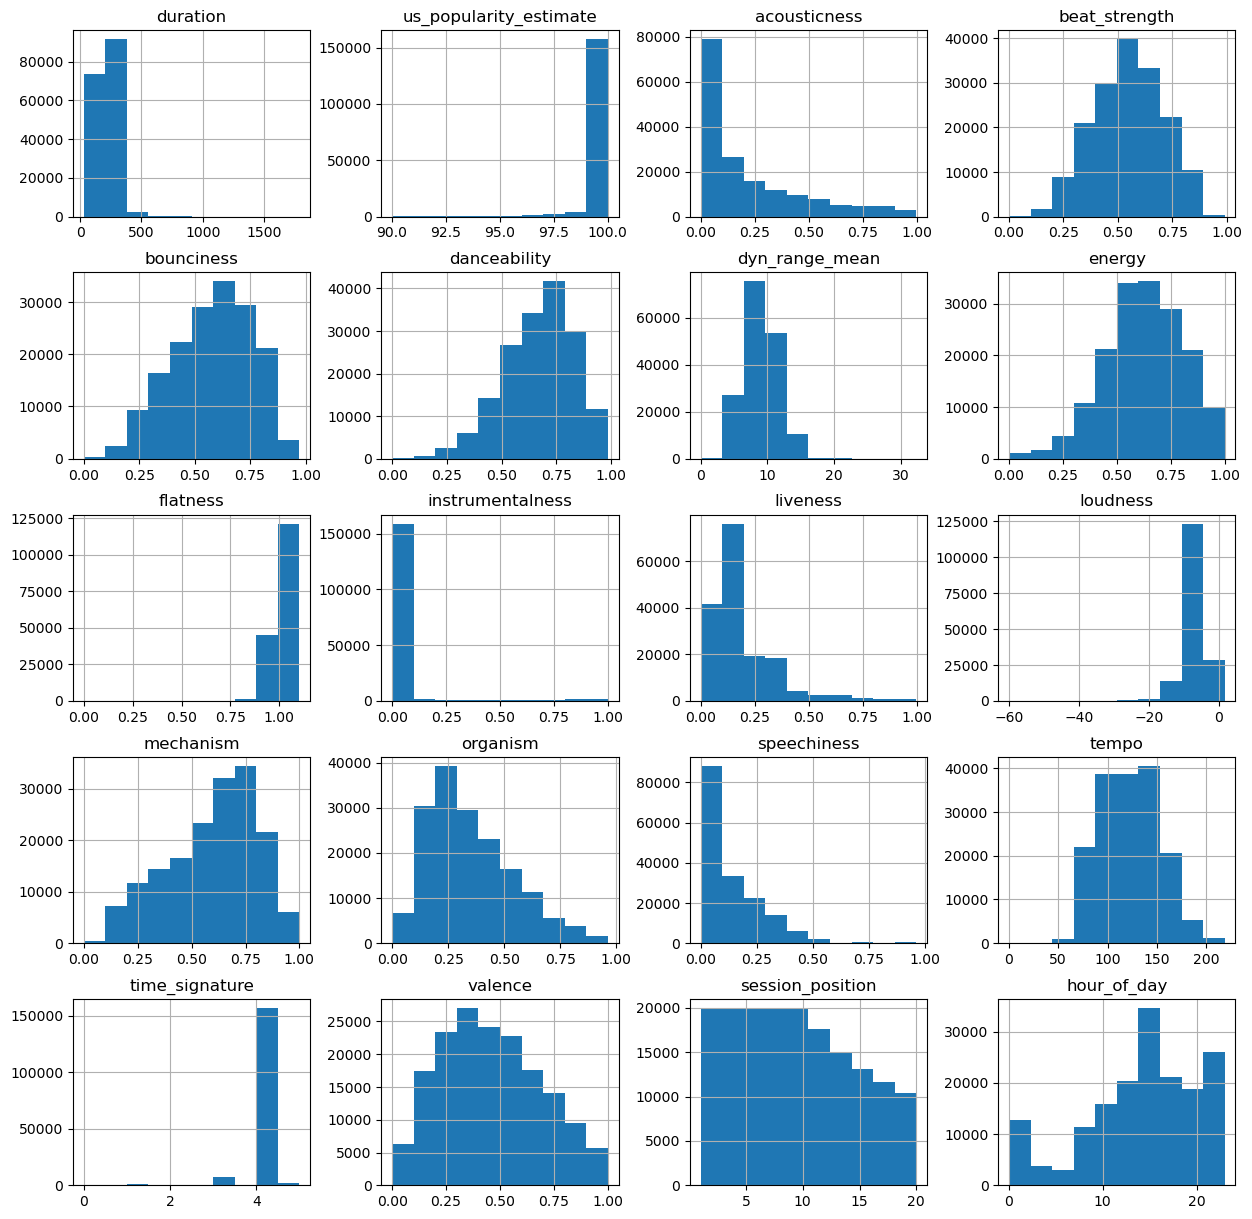

In [467]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
df[tf_features + log_features].hist(ax = ax)
plt.show()

Quick note about the cell below: I was applying normalisation before training and model and this can cause data leakage. Therefore I am commenting out most of this step for now and will re-implement later in the model pipeline step

In [468]:
# source: https://www.geeksforgeeks.org/normalize-a-column-in-pandas/

# copy the data
df_model_prep = df.copy()
# features_to_normalise = ['duration', 'us_popularity_estimate', 'dyn_range_mean', 'flatness', 'instrumentalness', 'loudness', 'tempo']
  
# # apply normalization techniques
# def normalise(df, columns):
#     '''Function to normalise a column in a pandas dataframe based on minimum and maximum values
    
#     Input: df - pandas dataframe; columns - list of column names
#     Output: df - pandas dataframe with normalised columns where required    
#     '''
#     df[columns] = ((df[columns] - df[columns].min()) / (df[columns].max() - df[columns].min()))
#     return df

# columns = features_to_normalise
# df_normalised = normalise(df_normalised, columns)

# df_normalised[columns].describe()

In [469]:
tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50704 entries, 0 to 50703
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_id                50704 non-null  object 
 1   duration                50704 non-null  float64
 2   release_year            50704 non-null  int64  
 3   us_popularity_estimate  50704 non-null  float64
 4   acousticness            50704 non-null  float64
 5   beat_strength           50704 non-null  float64
 6   bounciness              50704 non-null  float64
 7   danceability            50704 non-null  float64
 8   dyn_range_mean          50704 non-null  float64
 9   energy                  50704 non-null  float64
 10  flatness                50704 non-null  float64
 11  instrumentalness        50704 non-null  float64
 12  key                     50704 non-null  int64  
 13  liveness                50704 non-null  float64
 14  loudness                50704 non-null

In [470]:
# Dummy categorical variables
df_model_prep = pd.get_dummies(df_model_prep, prefix=None, prefix_sep='_', dummy_na=False, 
                          columns=['context_type','hist_user_behavior_reason_start', 'hist_user_behavior_reason_end', 'mode', 'time_signature'])

In [471]:
df_model_prep.describe()

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hour_of_day,duration,...,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone,mode_major,mode_minor,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
count,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,...,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000
mean,9.325911,17.651823,0.040904,0.767602,0.146635,0.172832,0.038909,0.046259,14.193084,215.893484,...,0.003354,0.001590,0.343704,0.613909,0.386091,0.000232,0.006058,0.044949,0.935793,0.012968
std,5.457638,3.422025,0.198069,0.422363,0.353742,0.378103,0.367295,0.606558,5.996243,60.223626,...,0.057813,0.039848,0.474945,0.486853,0.486853,0.015240,0.077597,0.207192,0.245121,0.113135
min,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.013330,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,15.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000,183.503403,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,9.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,15.000000,212.027023,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,14.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.000000,240.800003,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,20.000000,20.000000,1.000000,1.000000,1.000000,1.000000,60.000000,151.000000,23.000000,1787.760986,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [472]:
model_features_1 = ['session_position', 'context_switch', 'no_pause_before_play', 
            'short_pause_before_play', 'long_pause_before_play', 'hist_user_behavior_is_shuffle',
            'hour_of_day', 'premium', 'duration', 'us_popularity_estimate',
            'acousticness', 'beat_strength', 'bounciness', 'danceability',
            'dyn_range_mean', 'energy', 'flatness', 'instrumentalness','liveness', 
            'loudness', 'mechanism', 'organism', 'speechiness',
            'tempo', 'valence', 'acoustic_vector_0',
            'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
            'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
            'acoustic_vector_7', 'context_type_catalog', 'context_type_charts',
            'context_type_editorial_playlist', 'context_type_personalized_playlist',
            'context_type_radio', 'context_type_user_collection',
            'hist_user_behavior_reason_start_appload',
            'hist_user_behavior_reason_start_backbtn',
            'hist_user_behavior_reason_start_clickrow',
            'hist_user_behavior_reason_start_endplay',
            'hist_user_behavior_reason_start_fwdbtn',
            'hist_user_behavior_reason_start_playbtn',
            'hist_user_behavior_reason_start_remote',
            'hist_user_behavior_reason_start_trackdone',
            'hist_user_behavior_reason_start_trackerror', 
            'mode_major', 'mode_minor']

In [473]:
def heatmap(df, feature_list):
    plt.figure(figsize=(20, 16))
    heatmap = sns.heatmap(df[feature_list].corr(), vmin=-1, vmax=1)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

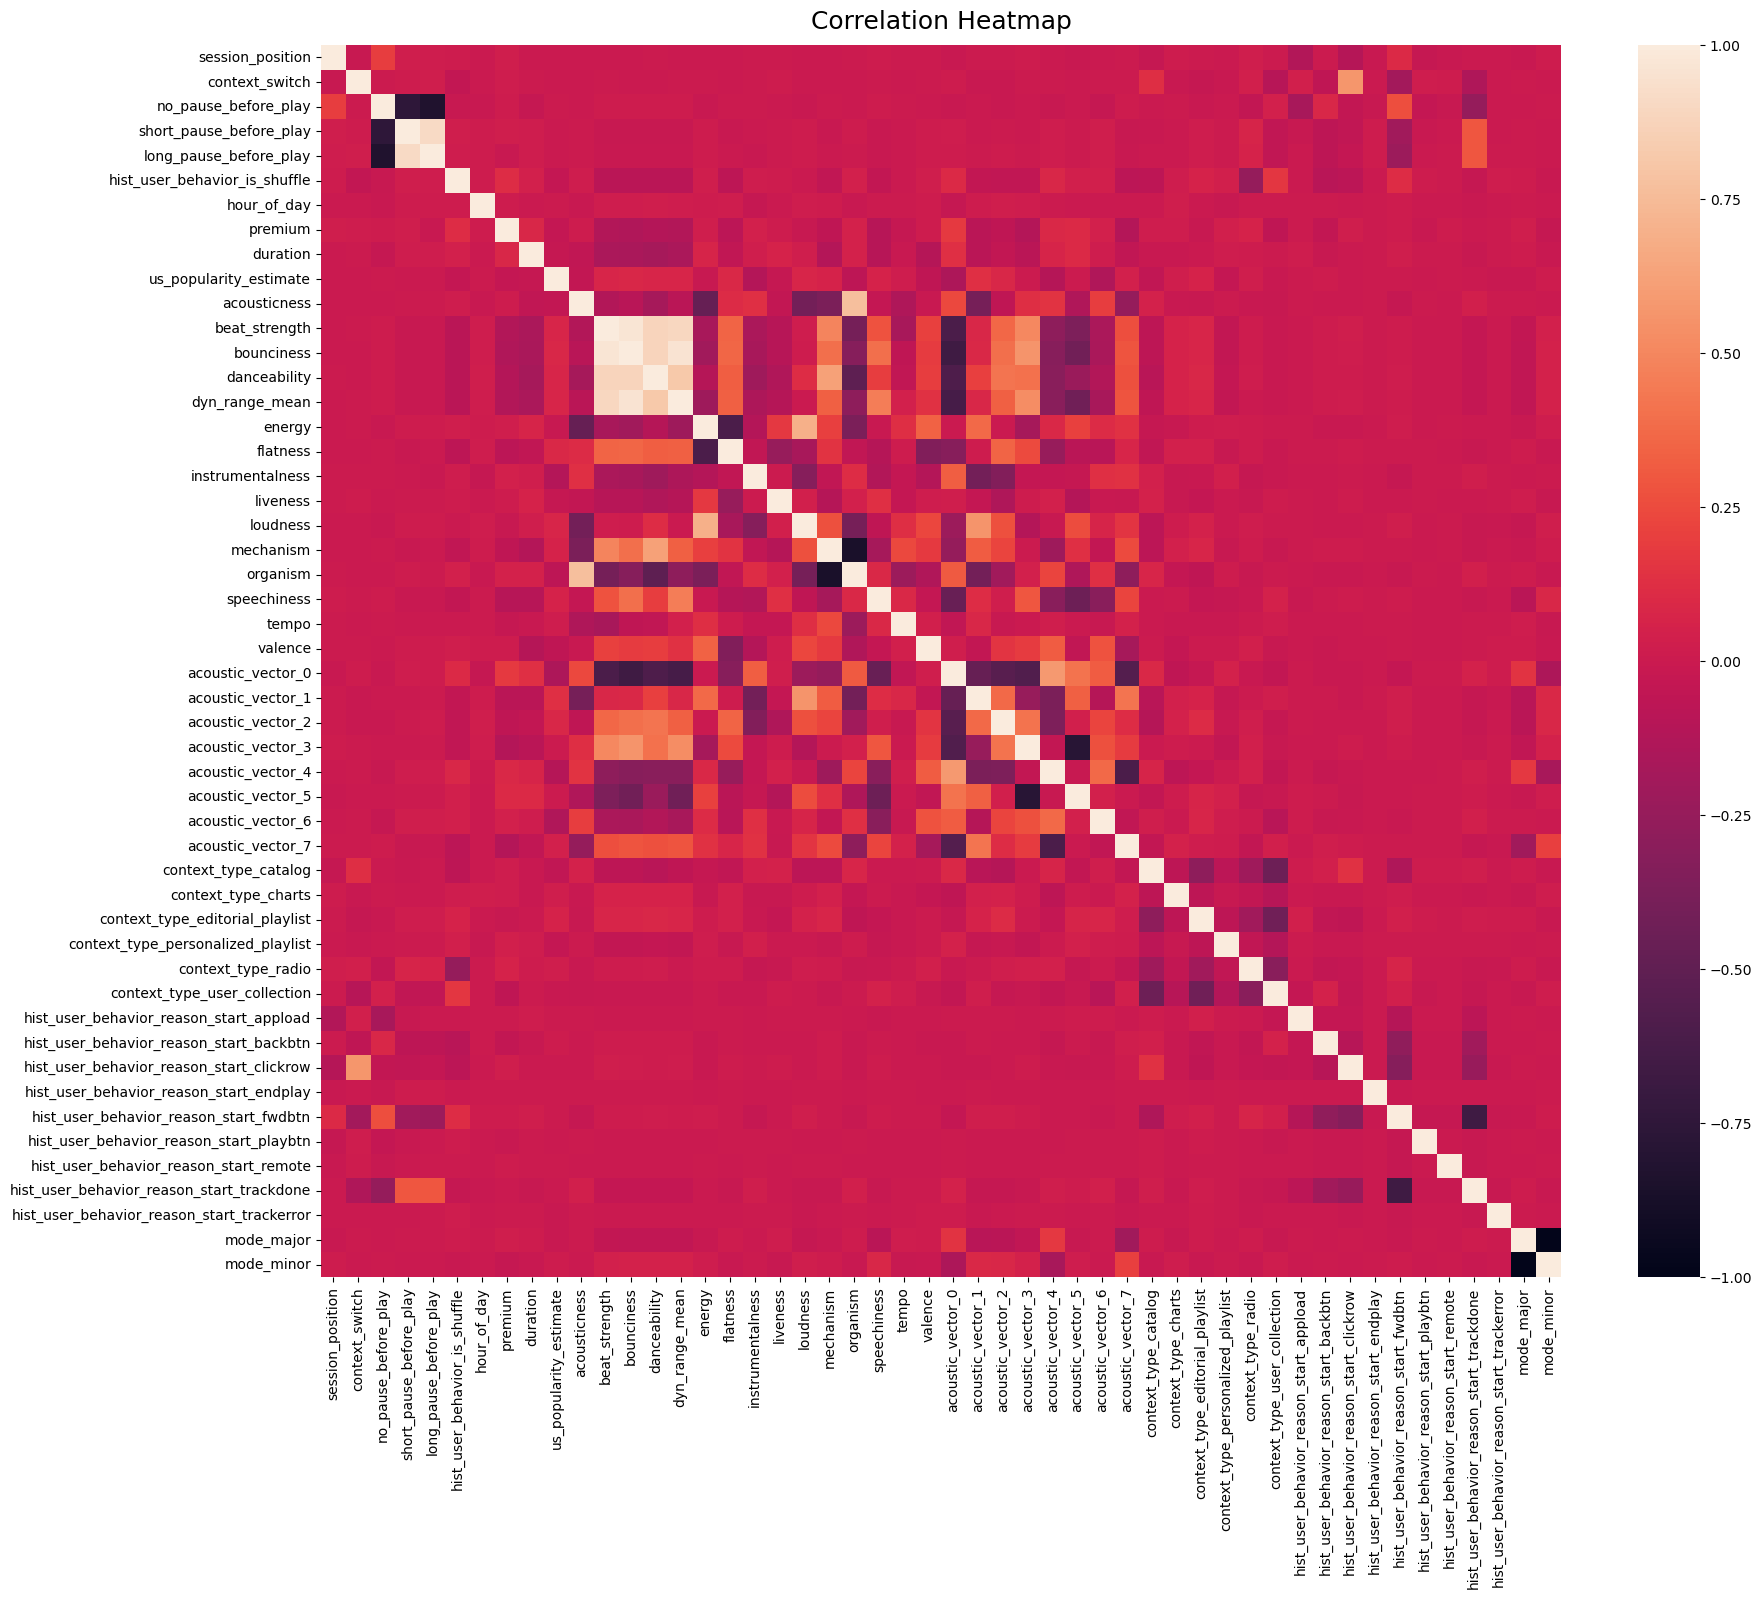

In [474]:
heatmap(df_model_prep, model_features_1)

In [475]:
# Reduce features by removing those with strong correlations and one out of each set of categorical features
# (because all information about that feature will be contained in the others in the group)
features_to_remove = ['long_pause_before_play', 'short_pause_before_play', 'bounciness', 
                      'dyn_range_mean', 'flatness', 'acoustic_vector_0', 'acousticness',
                      'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5',
                      'organism', 'valence', 'context_type_editorial_playlist',
                      'context_type_catalog', 'hist_user_behavior_reason_start_fwdbtn', 
                      'mode_major']

In [476]:
final_features = [feat for feat in model_features_1 if feat not in features_to_remove]

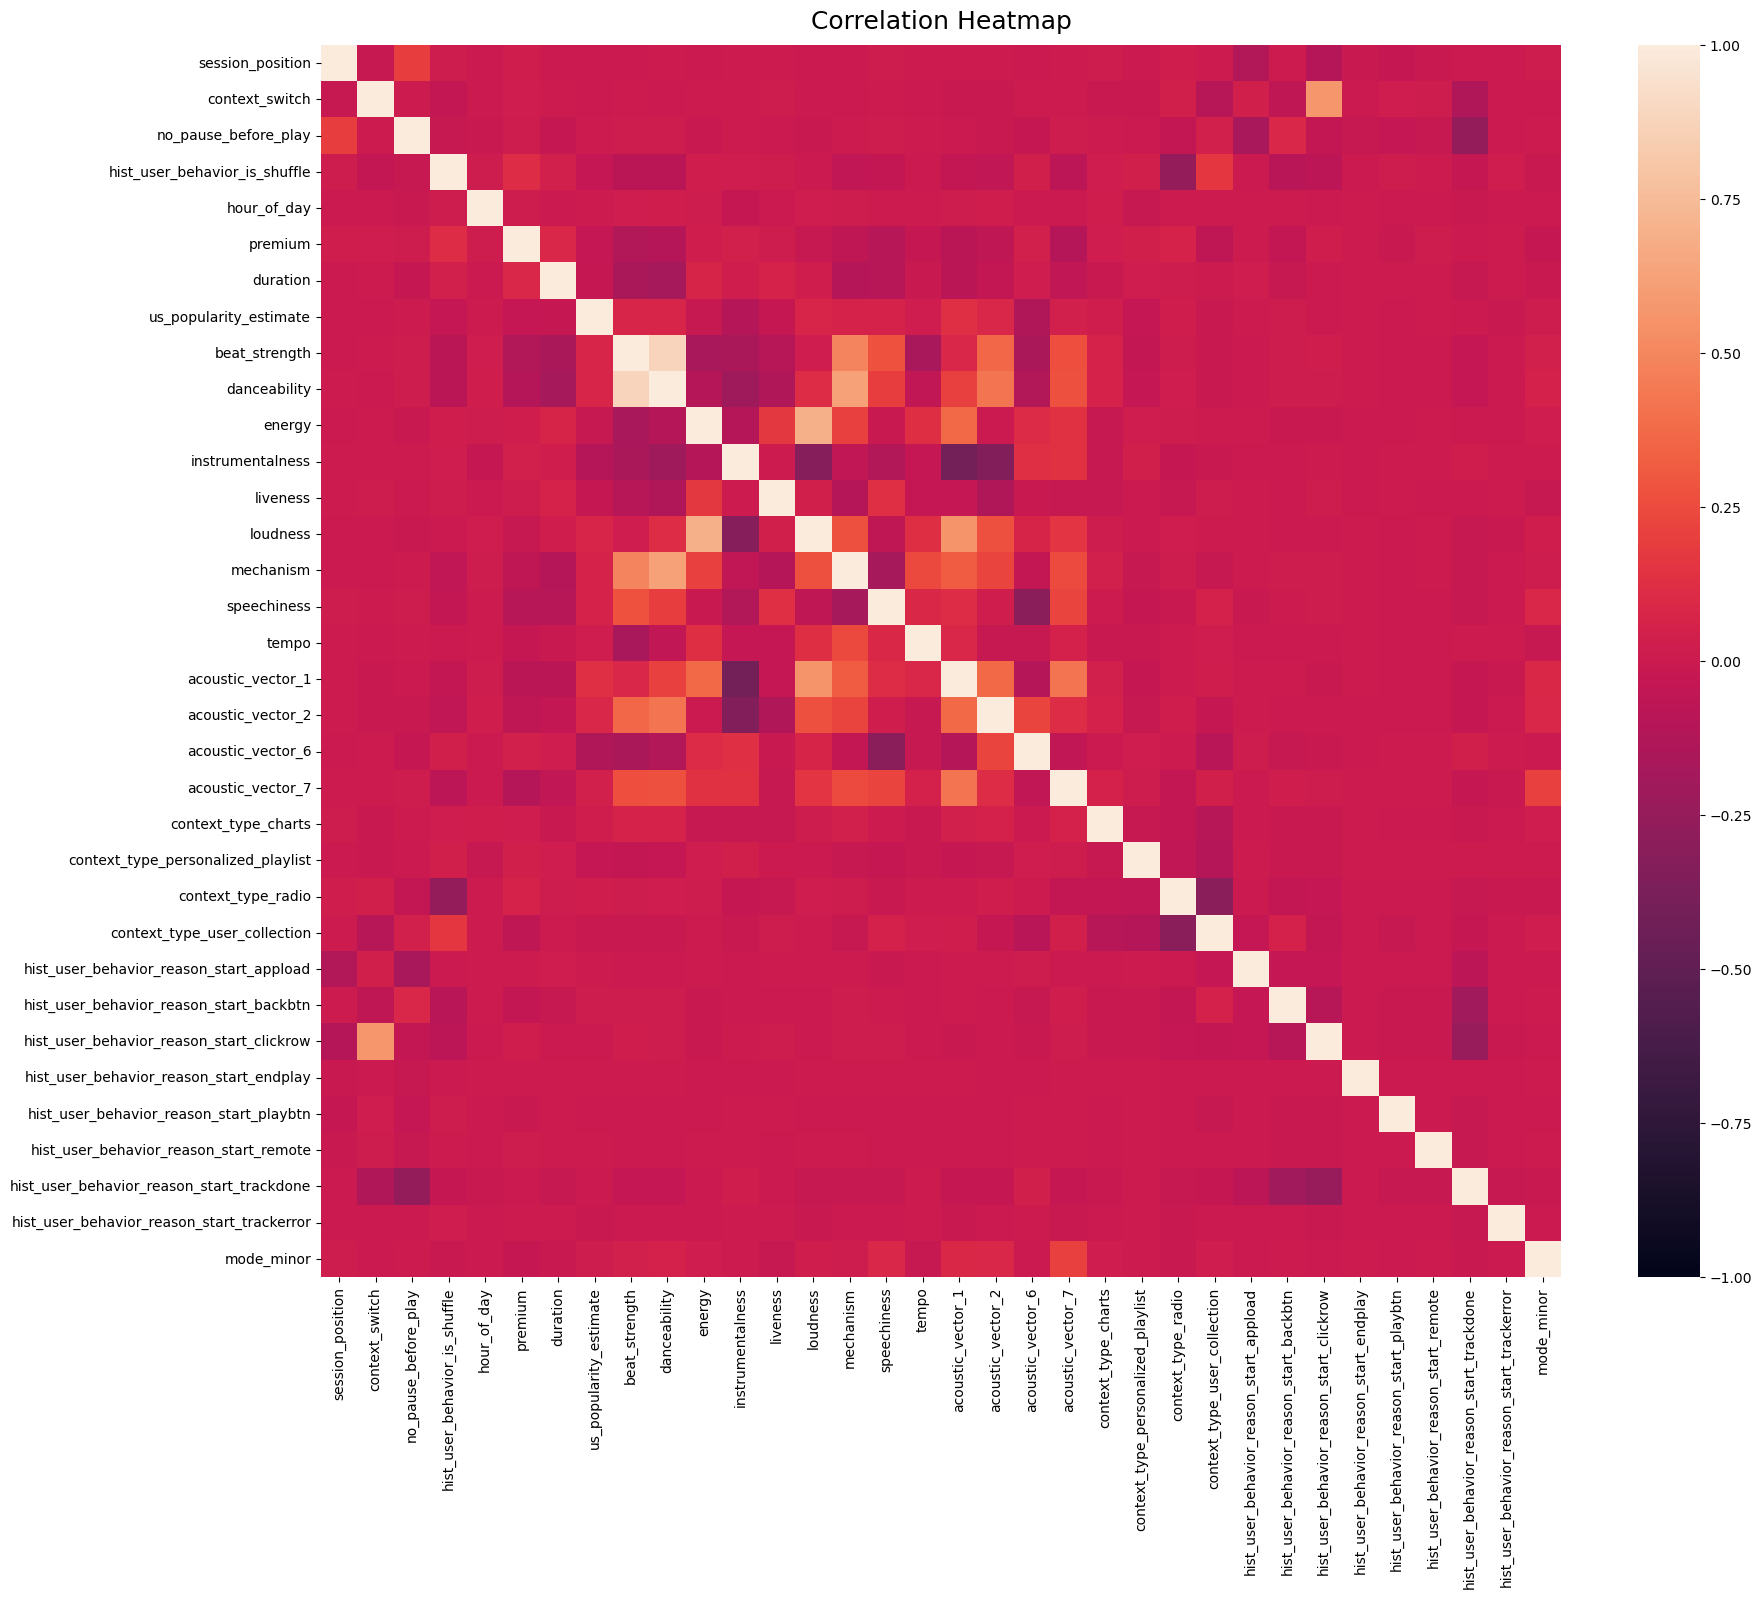

In [477]:
heatmap(df_model, final_features)

In [478]:
len(final_features)

34

In [481]:
target = 'skip_1'

In [486]:
df_model = df_model_prep[final_features]
df_model[target] = df[target]
df_model['session_id'] = df['session_id']

/Users/el_zy/opt/anaconda3/envs/jupyter-notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/el_zy/opt/anaconda3/envs/jupyter-notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [487]:
df_model.head()

,session_position,context_switch,no_pause_before_play,hist_user_behavior_is_shuffle,hour_of_day,premium,duration,us_popularity_estimate,beat_strength,danceability,...,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,mode_minor,skip_1,session_id
0,1,0,0,True,16,True,180.066666,99.968133,0.438551,0.653119,...,0,0,0,0,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e
1,7,0,0,False,17,True,180.066666,99.968133,0.438551,0.653119,...,0,0,0,0,0,0,0,0,False,0_00079a23-1600-486a-91bd-5208be0c745a
2,6,0,0,False,21,True,180.066666,99.968133,0.438551,0.653119,...,0,0,0,0,0,1,0,0,False,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb
3,9,0,1,False,18,True,180.066666,99.968133,0.438551,0.653119,...,0,0,0,0,0,0,0,0,False,0_013cc010-c476-4ad2-8972-73449e0b2ef4
4,7,0,0,True,19,False,180.066666,99.968133,0.438551,0.653119,...,0,0,0,0,0,1,0,0,False,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290


In [488]:
# List of session ids (to be used later)
session_ids = df_model['session_id'].tolist()

## Model building and evaluation

In [283]:
def session_id_list(df):
    '''Function to convert the session_id column of a dataframe to a list with unique values
    
    Input: df - pandas dataframe
    Output: session_id - list of unique session ids
    '''
    session_id = df['session_id'].value_counts().index.tolist()
    return session_id

In [284]:
# check none of the same elements across two lists
def common_member(a, b):
    '''Function to take two lists and return True if they have any of the same elements or False otherwise
    
    Input: a - list
            b - list
    Output: boolean to indicate whether they have overlapping elements
    '''
    a_set = set(a)
    b_set = set(b)
    if (a_set & b_set):
        return True
    else:
        return False

In [312]:
def train_test_split_shuffle(df):
    '''Function to apply a train test split using GroupShuffleSplit
    
    Input: df - pandas dataframe
    Output: X_train, y_train, X_test, y_test - dataframes corresponding to train and test splits
    '''
    # Define X_train, X_test, y_train, y_test using GroupShuffleSplit
    splitter = GroupShuffleSplit(test_size=.20, n_splits=5, random_state = 42)
    split = splitter.split(df, groups=df['session_id'])
    train_inds, test_inds = next(split)

    train = df.iloc[train_inds]
    test = df.iloc[test_inds]
    
    train_session_ids = session_id_list(train)
    test_session_ids = session_id_list(test)
    
    check = common_member(train_session_ids, test_session_ids)
    
    if check == False:
        print('Session id check passed: no overlap in session ids between test and train sets')
    else:
        print('Session id check failed: overlap in session ids between test and train sets')
        
    X_train, y_train, X_test, y_test = train[features], train[target], test[features], test[target]
    return X_train, y_train, X_test, y_test

In [286]:
# Split model data into target and feature variables
def train_test(df, target, features, shuffle_ind):
    # Create target dataset
    y = df[target]
    
    # Create feature dataset
    X = df[features]
    
    # Define X_train, X_test, y_train, y_test using train_test_split
    if shuffle_ind == 'no_shuffle':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    else:
        X_train, y_train, X_test, y_test = train_test_split_shuffle(df)
    
    return X_train, y_train, X_test, y_test

In [338]:
# Define function to fit model
def fit_model(model_type, X_train, y_train, X_test):
    '''Function to fit a model based on model type and test / train data
    
    Input: model_type - model to test
    Output: y_test_preds - predicted class labels for test set
            y_train_preds - predicted class labels for train set
    '''
    # Instantiate
    clf = model_type
    # Fit
    clf.fit(X_train, y_train) 

    #Predict
    y_test_preds = clf.predict(X_test) 
    y_train_preds = clf.predict(X_train)
    return clf, y_test_preds, y_train_preds

In [288]:
# Define function to display confusion matrix
def plot_conf_matrix(cm):
    '''Plot a confusion matrix
    
    Input: cm - created using the confusion_matrix function
    Output: None - displays a confusion matrix grid
    '''
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [293]:
# Define function to calculate and print binary classification metrics
def binary_metrics(y_test, y_test_preds, y_train, y_train_preds):
    '''Function to return binary classification metrics
    
    Input:  y_test - list of actual class labels for test set
            y_test_preds - list of predicted class labels for test set
    Output: None - metrics are printed
    '''
    # Calculate metrics
    cm = confusion_matrix(y_test, y_test_preds)
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tn+tp)/(tn+tp+fn+fp)
    fpr, tpr, thresholds = roc_curve(y_test, y_test_preds)
    c_stat = auc(fpr, tpr)
    
    # Print metrics
    
    # confusion matrix
    plot_conf_matrix(cm)
    
    # Print confusion matrix results
    print('True Negative: {} \nFalse Positive: {} \nFalse Negative: {} \nTrue Positive: {}'.format(tn, fp, fn, tp))
    
    # Accuracy
    print('\nAccuracy: {}'.format(accuracy))
    
    # c-statistic
    print('\nc-statistic: {}'.format(c_stat))
    
    # classification report (test)
    print('\nClassification report (test):\n{}'.format(classification_report(y_test, y_test_preds)))
    
    # classification report (train)
    print('\nClassification report (train):\n{}'.format(classification_report(y_train, y_train_preds)))

In [360]:
# Code taken from Udacity Nanodegree course

def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data to extract column names from
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['feature'] = X_train.columns
    coefs_df['coefs'] = clf.coef_[0]
    coefs_df['abs_coefs'] = np.abs(clf.coef_[0])
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [366]:
def plot_model_features(coef_df):
    plt.style.use('default')
    plt.subplots(figsize=(10,5))
    plt.bar(coef_df['feature'], coef_df['coefs'], color='purple')
    plt.title('Feature impact on skip probability', fontsize = 14)
    plt.xlabel('Feature')
    plt.ylabel('Coefficient', fontsize = 10)
    plt.tick_params(axis = 'x', labelrotation = 90, labelsize = 10)
    plt.savefig('Classification feature coefficients', bbox_inches='tight')
    plt.show()

In [362]:
# Define function to run the model
def run_model(df, target, features, model_type, shuffle_ind='shuffle', print_coef='False'):
    '''Function to run the model building and evaluation steps
    
    Input: model_type - model to test
    Ouput: None - displays coefficient (if applicable) and classification metrics
    '''
    # Split into train and test
    X_train, y_train, X_test, y_test = train_test(df, target, features, shuffle_ind)
    
    # Instantiate and fit model
    clf, y_test_preds, y_train_preds = fit_model(model_type, X_train, y_train, X_test)
    
    # Investigate coefficients
    if print_coef == True:
        coef_df = coef_weights(clf.coef_, X_train)
        plot_model_features(coef_df)
    else:
        pass
    
    # Calculate and print metrics
    binary_metrics(y_test, y_test_preds, y_train, y_train_preds)

Model test: Decision Tree

In [326]:
# Define target and feature variables
target = 'skip_1'
features = ['session_position', 'context_switch', 'no_pause_before_play', 
            'short_pause_before_play', 'long_pause_before_play', 'hist_user_behavior_is_shuffle',
            'hour_of_day', 'premium', 'duration', 'us_popularity_estimate',
            'acousticness', 'beat_strength', 'bounciness', 'danceability',
            'dyn_range_mean', 'energy', 'flatness', 'instrumentalness','liveness', 
            'loudness', 'mechanism', 'organism', 'speechiness',
            'tempo', 'valence', 'acoustic_vector_0',
            'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
            'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
            'acoustic_vector_7', 'context_type_catalog', 'context_type_charts',
            'context_type_editorial_playlist', 'context_type_personalized_playlist',
            'context_type_radio', 'context_type_user_collection',
            'hist_user_behavior_reason_start_appload',
            'hist_user_behavior_reason_start_backbtn',
            'hist_user_behavior_reason_start_clickrow',
            'hist_user_behavior_reason_start_endplay',
            'hist_user_behavior_reason_start_fwdbtn',
            'hist_user_behavior_reason_start_playbtn',
            'hist_user_behavior_reason_start_remote',
            'hist_user_behavior_reason_start_trackdone',
            'hist_user_behavior_reason_start_trackerror',
            'hist_user_behavior_reason_end_backbtn',
            'hist_user_behavior_reason_end_clickrow',
            'hist_user_behavior_reason_end_endplay',
            'hist_user_behavior_reason_end_fwdbtn',
            'hist_user_behavior_reason_end_logout',
            'hist_user_behavior_reason_end_remote',
            'hist_user_behavior_reason_end_trackdone', 
            'mode_major', 'mode_minor']
# No song end metrics like 'end_user_behaviour' because you wouldn't be able to 
# see this before predicting whether someone will skip or not

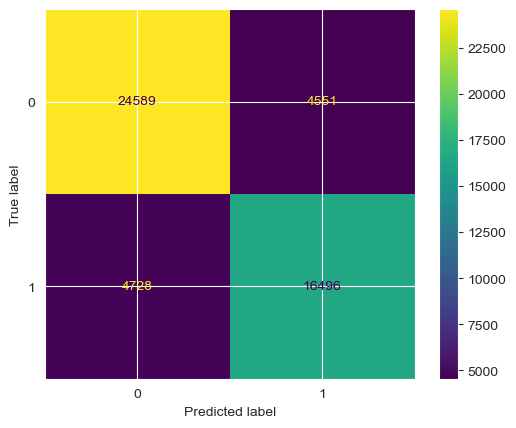

True Negative: 24589 
False Positive: 4551 
False Negative: 4728 
True Positive: 16496

Accuracy: 0.8157612580414582

c-statistic: 0.8105281222925006

Classification report (test):
              precision    recall  f1-score   support

       False       0.84      0.84      0.84     29140
        True       0.78      0.78      0.78     21224

    accuracy                           0.82     50364
   macro avg       0.81      0.81      0.81     50364
weighted avg       0.82      0.82      0.82     50364


Classification report (train):
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     67978
        True       1.00      1.00      1.00     49538

    accuracy                           1.00    117516
   macro avg       1.00      1.00      1.00    117516
weighted avg       1.00      1.00      1.00    117516



In [333]:
model = DecisionTreeClassifier()
run_model(df_model, target, features, model, 'no_shuffle')

In [155]:
# Perfectly fitted to training data which indicates overfitting

In [105]:
# Try a different model
# Logistic regression

Model test: Logistic Regression

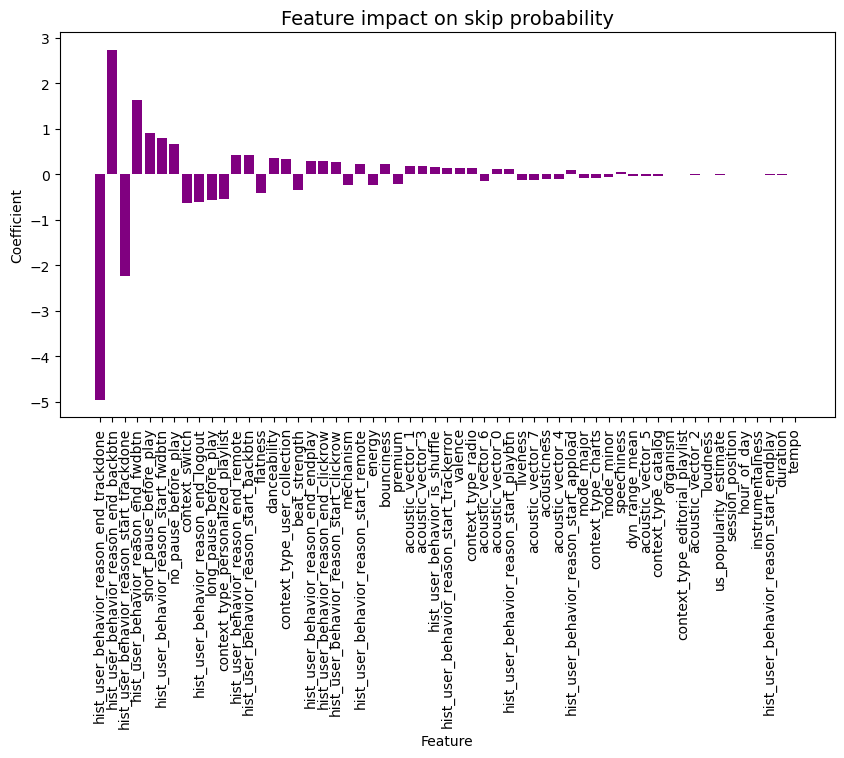

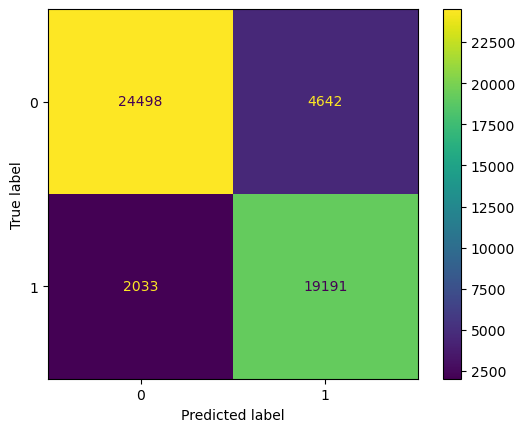

True Negative: 24498 
False Positive: 4642 
False Negative: 2033 
True Positive: 19191

Accuracy: 0.8674648558494162

c-statistic: 0.8724561406118505

Classification report (test):
              precision    recall  f1-score   support

       False       0.92      0.84      0.88     29140
        True       0.81      0.90      0.85     21224

    accuracy                           0.87     50364
   macro avg       0.86      0.87      0.87     50364
weighted avg       0.87      0.87      0.87     50364


Classification report (train):
              precision    recall  f1-score   support

       False       0.92      0.84      0.88     67978
        True       0.81      0.90      0.85     49538

    accuracy                           0.87    117516
   macro avg       0.86      0.87      0.87    117516
weighted avg       0.87      0.87      0.87    117516



In [367]:
model = LogisticRegression(solver = 'liblinear')
run_model(df_model, target, features, model, shuffle_ind = 'no_shuffle', print_coef = True)

In [ ]:
# Top audio features are flatness, danceability, beat_strength

In [345]:
clf.coef_

array([[ 4.30473715e-03, -6.35924998e-01,  6.68508003e-01,
         9.08374103e-01, -5.56309411e-01,  1.57252165e-01,
         3.40745903e-03, -2.06515134e-01, -1.25541590e-03,
        -4.44663355e-03, -1.06209761e-01, -3.31372824e-01,
         2.20378521e-01,  3.63244005e-01, -3.24985300e-02,
        -2.28399755e-01, -4.13488567e-01,  3.20383798e-03,
        -1.22939779e-01,  5.80943056e-03, -2.37020521e-01,
         1.81561151e-02,  4.88069053e-02,  3.10805588e-04,
         1.49623733e-01,  1.28189179e-01,  1.79537213e-01,
        -6.74762835e-03,  1.77973836e-01, -1.03783584e-01,
        -3.02850007e-02, -1.35019160e-01, -1.11770337e-01,
        -2.62027244e-02, -7.85007819e-02,  8.40663241e-03,
        -5.36507049e-01,  1.38193016e-01,  3.40918077e-01,
         1.01419153e-01,  4.19118632e-01,  2.71750069e-01,
        -2.81283027e-03,  7.92874259e-01,  1.27190501e-01,
         2.28453474e-01, -2.24164154e+00,  1.49955451e-01,
         2.73487382e+00,  2.93884490e-01,  2.96452733e-0

In [344]:
coef_df = coef_weights(clf.coef_, X_train)
print('Top coefficients: {}'.format(coef_df.head(10)))

ValueError: Length of values (1) does not match length of index (57)

In [ ]:
# Better than decision tree in that it is not overfitting (similar results for testing and training sets)
# And has improved performance across all metrics

In [109]:
# Could we improve this by including metrics for previous track played? ..
# Also look at distribution of session position

In [110]:
# Are we getting overfitting because you're mixing up sessions? So a lot of detail is across sesssions
# How would this perform on unseen sessions?

Model test: Logistic Regression with Group Shuffle

Session id check passed: no overlap in session ids between test and train sets


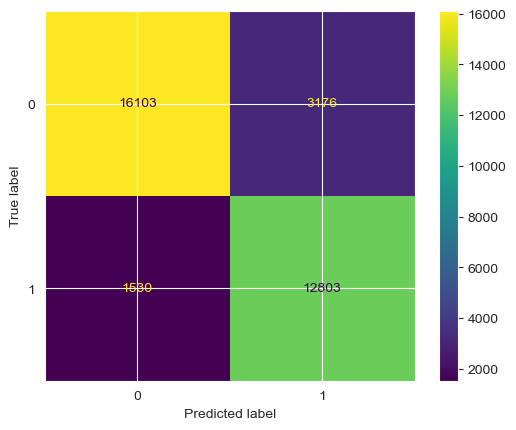

True Negative: 16103 
False Positive: 3176 
False Negative: 1530 
True Positive: 12803

Accuracy: 0.8599904795906224

c-statistic: 0.8642572482355048

Classification report (test):
              precision    recall  f1-score   support

       False       0.91      0.84      0.87     19279
        True       0.80      0.89      0.84     14333

    accuracy                           0.86     33612
   macro avg       0.86      0.86      0.86     33612
weighted avg       0.87      0.86      0.86     33612


Classification report (train):
              precision    recall  f1-score   support

       False       0.92      0.84      0.88     77839
        True       0.81      0.90      0.85     56429

    accuracy                           0.87    134268
   macro avg       0.87      0.87      0.87    134268
weighted avg       0.87      0.87      0.87    134268



In [300]:
model = LogisticRegression(solver = 'liblinear')
run_model(df_model, target, features, model, 'shuffle')

In [120]:
# cross-validation? revisit the cv pipelines in module 2

Model test: Logistic Regression with Group Shuffle and MinMax Scaling

In [301]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(solver = 'liblinear'))
])


# cv.split(X,y,groups=5)
# cv = GridSearchCV(pipeline, param_grid=parameters)

# cv.fit(X_train, y_train)
# y_pred = cv.predict(X_test)

In [123]:
# create a feature that is something like .. a closeness match between one song and the next in terms of audio features

In [124]:
# Alert! Data leakage when you are normalising the audio features in an earlier step. 
# You want to add this to the pipeline instead. Hey don't worry - already added as 'scaler' in pipeline

Session id check passed: no overlap in session ids between test and train sets


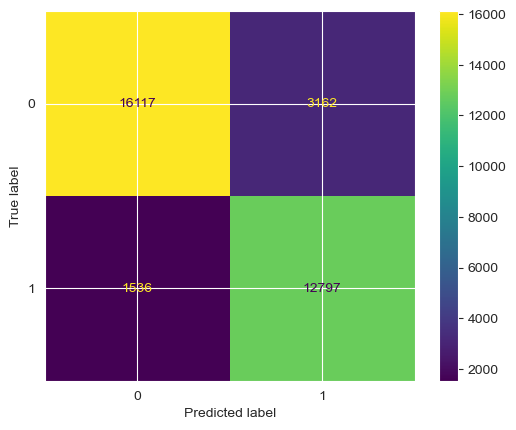

True Negative: 16117 
False Positive: 3162 
False Negative: 1536 
True Positive: 12797

Accuracy: 0.8602284898250625

c-statistic: 0.8644110304141696

Classification report (test):
              precision    recall  f1-score   support

       False       0.91      0.84      0.87     19279
        True       0.80      0.89      0.84     14333

    accuracy                           0.86     33612
   macro avg       0.86      0.86      0.86     33612
weighted avg       0.87      0.86      0.86     33612


Classification report (train):
              precision    recall  f1-score   support

       False       0.92      0.84      0.88     77839
        True       0.81      0.90      0.85     56429

    accuracy                           0.87    134268
   macro avg       0.87      0.87      0.87    134268
weighted avg       0.87      0.87      0.87    134268



In [302]:
model = pipeline
run_model(df_model, target, features, model, 'shuffle')

In [303]:
cv = GroupShuffleSplit(test_size=.20, n_splits=5, random_state = 42)

cross_val_score(pipeline, X, y, groups = session_ids, cv=cv)

array([0.86022849, 0.86727267, 0.86700586, 0.86735511, 0.86302228])

In [ ]:
# Cross validation scores all close which shows good random split? Double check this

Change to two models: one for first song in a session and then position 2-20

In [228]:
df_model.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone,mode_major,mode_minor,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,1,1,0,0,0,0,1,0
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,1,1,0,0,0,0,1,0
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,1,...,0,0,1,1,0,0,0,0,1,0
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,0,0,0,1,0,0,0,0,1,0


In [313]:
# Set up data for model_1
df_model_1 = df_model[df_model['session_position']==1]
features_1 = [feat for feat in features if feat != 'session_position']

In [311]:
df_model_1.shape

(10000, 75)

Test: Logistic Regression

In [314]:
# Set up pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(solver = 'liblinear'))
])

Session id check passed: no overlap in session ids between test and train sets


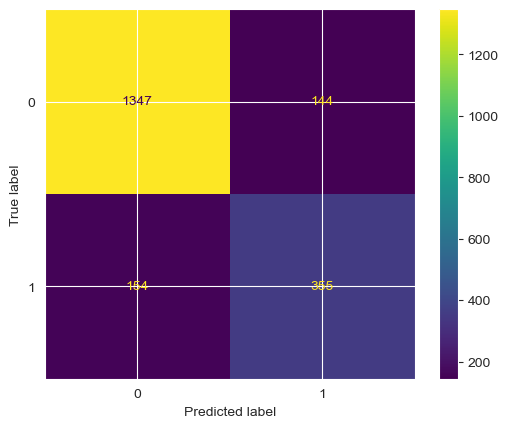

True Negative: 1347 
False Positive: 144 
False Negative: 154 
True Positive: 355

Accuracy: 0.851

c-statistic: 0.8004332478169608

Classification report (test):
              precision    recall  f1-score   support

       False       0.90      0.90      0.90      1491
        True       0.71      0.70      0.70       509

    accuracy                           0.85      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.85      0.85      0.85      2000


Classification report (train):
              precision    recall  f1-score   support

       False       0.90      0.90      0.90      5878
        True       0.72      0.71      0.71      2122

    accuracy                           0.85      8000
   macro avg       0.81      0.80      0.81      8000
weighted avg       0.85      0.85      0.85      8000



In [315]:
# Run model
model = pipeline
run_model(df_model_1, target, features_1, model, shuffle_ind='shuffle')

In [322]:
# Set up pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', xgb.XGBClassifier())
])

Session id check passed: no overlap in session ids between test and train sets


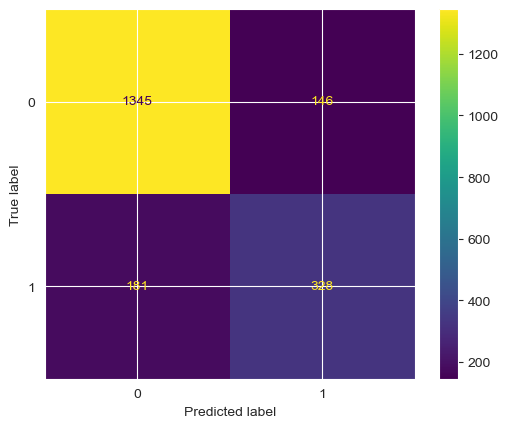

True Negative: 1345 
False Positive: 146 
False Negative: 181 
True Positive: 328

Accuracy: 0.8365

c-statistic: 0.7732399636851891

Classification report (test):
              precision    recall  f1-score   support

       False       0.88      0.90      0.89      1491
        True       0.69      0.64      0.67       509

    accuracy                           0.84      2000
   macro avg       0.79      0.77      0.78      2000
weighted avg       0.83      0.84      0.83      2000


Classification report (train):
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      5878
        True       0.98      0.97      0.98      2122

    accuracy                           0.99      8000
   macro avg       0.98      0.98      0.98      8000
weighted avg       0.99      0.99      0.99      8000



In [323]:
# Run model
model = pipeline
run_model(df_model_1, target, features_1, model, shuffle_ind='shuffle')

In [ ]:
# Looks to be overfitting ... could try some different hyperparameters using grid search?

In [ ]:
# Hang on two ticks .. I'd like to understand which features are driving most of the classification decision.
# Did this in project 1 - take a look at that to see what you did

In [ ]:
# New features: Distance to average of skipped tracks, distance to average of unskipped tracks

## Data pre-processing 2

Going to attempt to build four models:
1. For session position 1 (A)
2. Session position 2-20 - Prior tracks all skipped (B)
3. Session position 2-20 - Prior tracks not skipped (C)
4. Session position 2-20 - Prior tracks a mix of skipped / not skipped (D)

Reason being my hypothesis is that information about songs already skipped / not skipped will help us to predict whether following songs will be skipped or not. Just a note: do counts of these just to check you'll have enough data to train on

In [489]:
df_model.head()

,session_position,context_switch,no_pause_before_play,hist_user_behavior_is_shuffle,hour_of_day,premium,duration,us_popularity_estimate,beat_strength,danceability,...,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,mode_minor,skip_1,session_id
0,1,0,0,True,16,True,180.066666,99.968133,0.438551,0.653119,...,0,0,0,0,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e
1,7,0,0,False,17,True,180.066666,99.968133,0.438551,0.653119,...,0,0,0,0,0,0,0,0,False,0_00079a23-1600-486a-91bd-5208be0c745a
2,6,0,0,False,21,True,180.066666,99.968133,0.438551,0.653119,...,0,0,0,0,0,1,0,0,False,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb
3,9,0,1,False,18,True,180.066666,99.968133,0.438551,0.653119,...,0,0,0,0,0,0,0,0,False,0_013cc010-c476-4ad2-8972-73449e0b2ef4
4,7,0,0,True,19,False,180.066666,99.968133,0.438551,0.653119,...,0,0,0,0,0,1,0,0,False,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290


In [531]:
print(df_model[(df_model['session_position']==1)&(df_model['skip_1']==True)])

        session_position  context_switch  no_pause_before_play  \
46                     1               0                     0   
157                    1               0                     0   
163                    1               0                     0   
359                    1               0                     0   
374                    1               0                     0   
...                  ...             ...                   ...   
167209                 1               0                     0   
167376                 1               0                     0   
167516                 1               0                     0   
167782                 1               0                     0   
167813                 1               0                     0   

        hist_user_behavior_is_shuffle  hour_of_day  premium    duration  \
46                              False           17    False  236.796371   
157                             False           22     Tr

In [490]:
df_model.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            167870, 167871, 167872, 167873, 167874, 167875, 167876, 167877,
            167878, 167879],
           dtype='int64', length=167880)

In [618]:
df_model_2 = df_model.sort_values(by=['session_id','session_position']).reset_index().copy()

In [620]:
# Create look back skip rates
look_back_cols = []
for i in range(19):
    col_name = str(i+1)+'_track_prior_skip_1'
    df_model_2[col_name] = df_model_2.sort_values(by=['session_id','session_position']).groupby(['session_id'])['skip_1'].shift(i+1)
    look_back_cols.append(col_name)

In [621]:
look_back_cols

['1_track_prior_skip_1',
 '2_track_prior_skip_1',
 '3_track_prior_skip_1',
 '4_track_prior_skip_1',
 '5_track_prior_skip_1',
 '6_track_prior_skip_1',
 '7_track_prior_skip_1',
 '8_track_prior_skip_1',
 '9_track_prior_skip_1',
 '10_track_prior_skip_1',
 '11_track_prior_skip_1',
 '12_track_prior_skip_1',
 '13_track_prior_skip_1',
 '14_track_prior_skip_1',
 '15_track_prior_skip_1',
 '16_track_prior_skip_1',
 '17_track_prior_skip_1',
 '18_track_prior_skip_1',
 '19_track_prior_skip_1']

In [623]:
model = []
for i in df_model_2.index:
    row = df_model_2.iloc[i]
    session_position = row['session_position']
    if session_position == 1:
        model_type = 'A'
    else:
        counter = 0
        for j in range(session_position-1):
            counter += int(row[str(j+1)+'_track_prior_skip_1'])
        if counter == 0:
            model_type = 'C'
        elif counter / (session_position-1) == 1:
            model_type = 'B'
        else:
            model_type = 'D'
    model.append(model_type)

In [624]:
df_model_2['model'] = model

In [634]:
df_model_2.head(30)

,index,session_position,context_switch,no_pause_before_play,hist_user_behavior_is_shuffle,hour_of_day,premium,duration,us_popularity_estimate,beat_strength,...,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,mode_minor,skip_1,session_id,model
0,0,1,0,0,True,16,True,180.066666,99.968133,0.438551,...,0,0,0,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,A
1,45,2,0,1,True,16,True,236.796371,99.896728,0.654804,...,0,0,0,0,1,0,1,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C
2,50,3,0,1,True,16,True,231.266663,99.999976,0.532155,...,0,0,0,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C
3,327,4,0,1,True,16,True,169.826675,99.995038,0.641756,...,0,0,0,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C
4,353,5,0,1,True,16,True,210.545258,99.998498,0.732428,...,0,0,0,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C
5,475,6,0,1,True,16,True,216.689484,99.997602,0.548632,...,0,0,0,0,1,0,1,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C
6,537,7,0,1,True,16,True,186.453323,99.861567,0.487708,...,0,0,0,0,0,0,0,True,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C
7,540,8,0,1,True,16,True,214.047348,97.243819,0.649367,...,0,0,0,0,0,0,0,True,0_00006f66-33e5-4de7-a324-2d18e439fc1e,D
8,541,9,0,1,True,16,True,218.260818,99.998451,0.818798,...,0,0,0,0,0,0,1,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,D
9,601,10,0,1,True,16,True,60.000000,99.957434,0.751500,...,0,0,0,0,0,0,1,True,0_00006f66-33e5-4de7-a324-2d18e439fc1e,D


In [626]:
df_model_2 = df_model_2.drop(columns = look_back_cols)

In [632]:
df_model_2['model'].value_counts()

D    110009
C     36348
B     11523
A     10000
Name: model, dtype: int64

In [633]:
sum(df_model_2['model'].value_counts())

167880

In [640]:
df_model_2.columns

Index(['index', 'session_position', 'context_switch', 'no_pause_before_play',
       'hist_user_behavior_is_shuffle', 'hour_of_day', 'premium', 'duration',
       'us_popularity_estimate', 'beat_strength', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mechanism', 'speechiness',
       'tempo', 'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_6',
       'acoustic_vector_7', 'context_type_charts',
       'context_type_personalized_playlist', 'context_type_radio',
       'context_type_user_collection',
       'hist_user_behavior_reason_start_appload',
       'hist_user_behavior_reason_start_backbtn',
       'hist_user_behavior_reason_start_clickrow',
       'hist_user_behavior_reason_start_endplay',
       'hist_user_behavior_reason_start_playbtn',
       'hist_user_behavior_reason_start_remote',
       'hist_user_behavior_reason_start_trackdone',
       'hist_user_behavior_reason_start_trackerror', 'mode_minor', 'skip_1',
       'session_id', 'mo

In [652]:
def zero_to_nan(x):
    if x == 0:
        result = np.nan
    else:
        result = x
    return result

In [655]:
df_model_2['danceability_True'] = (df_model_2['skip_1'] * df_model_2['danceability']).apply(zero_to_nan)
df_model_2['danceability_False'] = (abs(df_model_2['skip_1']-1) * df_model_2['danceability']).apply(zero_to_nan)

In [656]:
df_model_2.head()

,index,session_position,context_switch,no_pause_before_play,hist_user_behavior_is_shuffle,hour_of_day,premium,duration,us_popularity_estimate,beat_strength,...,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,mode_minor,skip_1,session_id,model,danceability_True,danceability_False
0,0,1,0,0,True,16,True,180.066666,99.968133,0.438551,...,0,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,A,NaN,0.653119
1,45,2,0,1,True,16,True,236.796371,99.896728,0.654804,...,0,0,1,0,1,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C,NaN,0.877393
2,50,3,0,1,True,16,True,231.266663,99.999976,0.532155,...,0,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C,NaN,0.679719
3,327,4,0,1,True,16,True,169.826675,99.995038,0.641756,...,0,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C,NaN,0.864881
4,353,5,0,1,True,16,True,210.545258,99.998498,0.732428,...,0,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C,NaN,0.857778


In [672]:
df_model_2 = df_model_2.sort_values(by=['session_id', 'session_position'])

In [686]:
dance_groupby = df_model_2.sort_values(by=['session_id', 'skip_1']).groupby(['session_id','skip_1'])[['danceability_True','danceability_False']].expanding().mean().reset_index().head(20)

In [689]:
dance_groupby.head(20)

,session_id,skip_1,level_2,danceability_True,danceability_False
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,False,0,NaN,0.653119
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,False,1,NaN,0.765256
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,False,2,NaN,0.736744
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,False,3,NaN,0.768778
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,False,4,NaN,0.786578
5,0_00006f66-33e5-4de7-a324-2d18e439fc1e,False,5,NaN,0.754895
6,0_00006f66-33e5-4de7-a324-2d18e439fc1e,False,8,NaN,0.784822
7,0_00006f66-33e5-4de7-a324-2d18e439fc1e,False,13,NaN,0.782051
8,0_00006f66-33e5-4de7-a324-2d18e439fc1e,False,14,NaN,0.786605
9,0_00006f66-33e5-4de7-a324-2d18e439fc1e,False,15,NaN,0.772821


In [670]:
# stack overflow coming to the rescue again
# https://stackoverflow.com/questions/56799202/pandas-groupby-and-cumulative-mean-of-previous-rows-in-group
df_model_2 = df_model_2.sort_values(by=['session_id','skip_1','session_position'])
df_model_2['danceability_True_avg'] = df_model_2.groupby(['session_id', 'skip_1'])['danceability'].apply(lambda x: x.shift().expanding(1).mean())

In [671]:
df_model_2.head()

,index,session_position,context_switch,no_pause_before_play,hist_user_behavior_is_shuffle,hour_of_day,premium,duration,us_popularity_estimate,beat_strength,...,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,mode_minor,skip_1,session_id,model,danceability_True,danceability_False,danceability_True_avg
0,0,1,0,0,True,16,True,180.066666,99.968133,0.438551,...,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,A,NaN,0.653119,NaN
1,45,2,0,1,True,16,True,236.796371,99.896728,0.654804,...,0,1,0,1,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C,NaN,0.877393,0.653119
2,50,3,0,1,True,16,True,231.266663,99.999976,0.532155,...,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C,NaN,0.679719,0.765256
3,327,4,0,1,True,16,True,169.826675,99.995038,0.641756,...,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C,NaN,0.864881,0.736744
4,353,5,0,1,True,16,True,210.545258,99.998498,0.732428,...,0,1,0,0,False,0_00006f66-33e5-4de7-a324-2d18e439fc1e,C,NaN,0.857778,0.768778


In [ ]:
# new features to create
df_model_2['danceability_True_avg']
df_model_2['danceability_False_avg']

df_model_2['beat_strength_True_avg']
df_model_2['beat_strength_False_avg']

df_model_2['energy_True_avg']
df_model_2['energy_False_avg']

In [645]:
skip_groupby = df_model_2[df_model_2['session_position']<=2].sort_values(by=['session_id','session_position']).groupby(by=['session_id', 'session_position'])['skip_1'].agg('sum')
dance_groupby = df_model_2[df_model_2['session_position']<=2].sort_values(by=['session_id','session_position']).groupby(by=['session_id', 'session_position'])['danceability'].agg('mean')

In [661]:
test = []
for i in df_model_2.index:
    row = df_model_2.iloc[i]
    session_ind = row['session_id']
    session_position = row['session_position']
    if row['model'] == 'A' or row['model'] == 'C':
        output = np.nan
    else:
        output = df_model_2.groupby(['session_id','session_position'])['danceability_True'].shift(1).rolling().mean()
    test.append(output)

TypeError: rolling() missing 1 required positional argument: 'window'

In [642]:
# Create look back audio feature averages
test_dance_True_avg = []
for j in df_model_2.index:
    session_position = df_model_2['session_position'].iloc[j]
    test_danceability_True = []
    for i in range(session_position):
        test_danceability_True.append(df_model_2.sort_values(by=['session_id','session_position']).groupby(['session_id'])['skip_1'].shift(i+1)
                                     *df_model_2.sort_values(by=['session_id','session_position']).groupby(['session_id'])['danceability'].shift(i+1))
    test_dance_True_avg.append(sum(test_danceability_True) / len(test_danceability_True))

KeyboardInterrupt: 

In [ ]:
def filter_data(df, model):
    data = df[df['model']==model]
    return data

### Model A

In [636]:
df_model_A = filter_data(df_model_2, 'A')

### Model B

In [637]:
df_model_B = filter_data(df_model_2, 'B')

### Model C

In [638]:
df_model_C = filter_data(df_model_2, 'C')

### Model D

In [639]:
df_model_D = filter_data(df_model_2, 'D')

## Ideas after taking a break for a few weeks

- Different models for position 1 in a session vs 2-20 (because we can use features of prior tracks to hopefully improve performance)
    - Note that you don't have to worry about the GroupShuffleSplit for modelling position one because there will only be one per session
    - Note we probably want a model that can handle nulls, like xgboost. This is because I'll probably want a feature that includes difference to the average audio features on unskipped songs so far. But if all songs prior in the session have been skipped, you wouldn't necessarily have that
    - Reminder to look at correlations between features
- Implement a recommendation engine using things like popularity scores, similarity with other sessions, skip rates, songs in session so far. Note this could be a comment at the end of the project for extensions to this work. Or keep it simple. Really easy to get tangled here and make it too difficult

- Think about writing perhaps a python package to help with some of this?
- What about unit tests?

Steps to follow today:
- Refactor code into readable chunks and functions, maybe even packages? Done
- Move normalisation from data pre-processing to model pipeline step. Done
- Create optimal model for first play in session.

## Recommendation engine